In [2]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization,Conv2DTranspose, GlobalMaxPooling2D, Conv2D, Reshape
import tensorflow as tf
from tqdm import tqdm
import numpy as np

In [50]:
class ConditionalGAN(keras.Model):
    def __init__(self, 
                 data_type : str = 'image', 
                 number_classes : int = 10,
                 num_channels : int  = 1,
                 problem_size = (28,28),
                 discriminator_structure : tuple = (32,64),
                 generator_structure : tuple = (16,16),
                 discriminator_optimizer : str = 'Adam',
                 generator_optimizer : str = 'Adam',
                 latent_dim : int = 32,
                 activation_discriminator : str = 'linear',
                 activation_generator : str = 'linear',
                 loss : str = 'binary_crossentropy'):

        super(ConditionalGAN, self).__init__()
        self.discriminator_structure = discriminator_structure
        self.generator_structure = generator_structure
        self.latent_dim = latent_dim
        self.activation_discriminator = activation_discriminator
        self.activation_generator = activation_generator
        self.loss = loss

        self.number_classes = number_classes
        self.data_type = data_type

        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer

        self.n_layers_discriminator = len(discriminator_structure)
        self.n_layers_generator = len(generator_structure)

        self.problem_size = problem_size

        self.generator_in_channels = latent_dim + number_classes
        self.discriminator_in_channels = num_channels + number_classes

        list_prob_size = list(self.problem_size)
        list_prob_size.append(number_classes)
        self.discriminator_in_shape = tuple(list_prob_size)

        self.create_initial_generator_discriminator()
        self.generator.describe()
        self.discriminator.describe()
        #self.generator = self.create_generator()
        #self.discriminator = self.create_discriminator()
        #print(self.generator_in_channels, self.discriminator_in_channels)
        self.compile()

        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    def create_initial_generator_discriminator(self):
        # Create the discriminator.
        discriminator = keras.Sequential(
            [
                keras.layers.InputLayer((28, 28, self.discriminator_in_channels)),
                keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
                keras.layers.LeakyReLU(alpha=0.2),
                keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
                keras.layers.LeakyReLU(alpha=0.2),
                keras.layers.GlobalMaxPooling2D(),
                keras.layers.Dense(1),
            ],
            name="discriminator",
        )

        # Create the generator.
        generator = keras.Sequential(
            [
                keras.layers.InputLayer((self.generator_in_channels,)),
                # We want to generate 128 + num_classes coefficients to reshape into a
                # 7x7x(128 + num_classes) map.
                keras.layers.Dense(7 * 7 * self.generator_in_channels),
                keras.layers.LeakyReLU(alpha=0.2),
                keras.layers.Reshape((7, 7, self.generator_in_channels)),
                keras.layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
                keras.layers.LeakyReLU(alpha=0.2),
                keras.layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
                keras.layers.LeakyReLU(alpha=0.2),
                keras.layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
            ],
            name="generator",
        )

        self.generator = generator
        self.discriminator = discriminator



    def create_generator(self):

        print("Generating Generator Network...")

        generator = keras.Sequential(
    [
        keras.layers.InputLayer((self.generator_in_channels,)),
        keras.layers.Dense(4 * 4 * self.generator_in_channels),
        keras.layers.Reshape((4, 4, self.generator_in_channels)),
        keras.layers.UpSampling2D((2,2)),
        keras.layers.Dropout(0.5),
        keras.layers.Conv2DTranspose(self.generator_structure[0], (5, 5), strides=(1, 1), padding="valid",activation="relu"),
        keras.layers.UpSampling2D((2,2)),
        keras.layers.Dropout(0.5),
        keras.layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding="valid"),
    ],
    name="generator",
)   
        generator.summary()
        return generator
        
        generator = Sequential(name='Generator')
        generator.add(tf.keras.layers.InputLayer(input_shape=(self.generator_in_channels)))

        if self.data_type.upper() == 'IMAGE' :
            generator.add(Dense(7*7 * self.generator_in_channels,activation = self.activation_generator))
            generator.add(Reshape((7, 7, self.generator_in_channels)))
            for layer in range(self.n_layers_generator):
                generator.add(Conv2DTranspose(self.generator_structure[layer],(4,4),strides=(2, 2), padding="same",activation = self.activation_generator))
            generator.add(Conv2D(1, (7, 7), padding="same", activation="sigmoid"))
        else :
            for layer in range(self.n_layers_generator):
                generator.add(Dense(self.generator_structure[layer],
                                    activation = self.activation_generator))
                if self.use_batch_norm_generator :
                    generator.add(BatchNormalization())

            generator.add(Dense(self.n_features,
                                activation = self.activation_generator))

        generator.summary()
        return generator


    def create_discriminator(self):

        print("Generating Discriminator Network...")


        discriminator = keras.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=(self.problem_size[0], 
                                                self.problem_size[1], 
                                                self.discriminator_in_channels)), 

        tf.keras.layers.Conv2D(self.discriminator_structure[0], (5,5), strides=(1, 1), padding="valid",activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.MaxPool2D((2,2)),

        tf.keras.layers.Conv2D(self.discriminator_structure[1], (5,5), strides=(1, 1), padding="valid",activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.MaxPool2D((2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1),
    ],
    name="Discriminator",
)       
        discriminator.summary()
        return discriminator

        discriminator = Sequential(name='Discriminator')
        discriminator.add(tf.keras.layers.InputLayer(input_shape=(self.problem_size[0], 
                                                                  self.problem_size[1], 
                                                                  self.discriminator_in_channels)))

        if self.data_type.upper() == 'IMAGE' :
            for layer in range(self.n_layers_discriminator):
                discriminator.add(Conv2D(self.discriminator_structure[layer], (3, 3), strides=(2, 2), padding="same"))
            discriminator.add(GlobalMaxPooling2D())
        else :

            for layer in range(self.n_layers_discriminator):
                discriminator.add(Dense(self.discriminator_structure[layer],
                                    activation = self.activation_discriminator))
                if self.use_batch_norm_discriminator:
                    discriminator.add(BatchNormalization())

        discriminator.add(Dense(1))
        discriminator.summary()

        return discriminator 

        

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self):
        super(ConditionalGAN, self).compile()
        self.d_optimizer = keras.optimizers.Adam(learning_rate=0.0003)
        self.g_optimizer = keras.optimizers.Adam(learning_rate=0.0003)
        self.loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)


    def generate_fake(self,n_fakes,label = None):

        if label is None :
            label_vec = keras.utils.to_categorical(np.random.randint(0,self.number_classes,size = n_fakes),self.number_classes)
            noise =  tf.repeat(tf.random.normal(shape=(1, self.latent_dim)),n_fakes,axis=0)
            noise_and_labels = tf.concat([noise, label_vec], 1)

        else :
            noise =  tf.random.normal(shape=(1, self.latent_dim))
            label = keras.utils.to_categorical([label],self.number_classes)
            noise_and_labels = tf.repeat(tf.concat([noise, label], 1),n_fakes,axis=0)

        return(self.generator.predict(noise_and_labels))
        

    def train_step(self, data):

        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[self.problem_size[0] * self.problem_size[1]]
        )
        image_one_hot_labels = tf.reshape(
            image_one_hot_labels, (-1, self.problem_size[0], self.problem_size[1], self.number_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
        combined_images = tf.concat(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)

        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)

        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

In [51]:
batch_size = 64
num_channels = 1
num_classes = 10
image_size = 28
latent_dim = 128


# We'll use all the available examples from both the training and test
# sets.
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_labels = np.concatenate([y_train, y_test])

# Scale the pixel values to [0, 1] range, add a channel dimension to
# the images, and one-hot encode the labels.
all_digits = all_digits.astype("float32") / 255.0
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
all_labels = keras.utils.to_categorical(all_labels, 10)

# Create tf.data.Dataset.
dataset = tf.data.Dataset.from_tensor_slices((all_digits, all_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

print(f"Shape of training images: {all_digits.shape}")
print(f"Shape of training labels: {all_labels.shape}")

Shape of training images: (70000, 28, 28, 1)
Shape of training labels: (70000, 10)


In [52]:
cond_gan = ConditionalGAN(num_channels = num_channels,
                          number_classes=num_classes,
                          problem_size=(image_size,image_size),
                          latent_dim=latent_dim,
                          discriminator_structure = (128,128),
                          generator_structure=(128,128))

In [53]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

class PlotEpochCallback(keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
        generate = epoch%self.model.number_classes
        print('Plot fake number {}'.format(generate))
        imshow(self.model.generate_fake(1,generate)[0])
        plt.show()

In [54]:
callbacks = [PlotEpochCallback()]

In [1]:
cond_gan.fit(dataset,epochs=100,callbacks=callbacks)

NameError: name 'cond_gan' is not defined

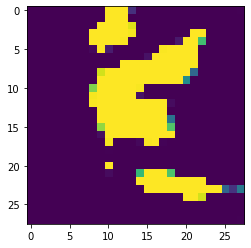

In [61]:
imshow(cond_gan.generate_fake(1,5)[0])